# Generate data

In [1]:
import sys
import os
absFilePath = os.path.abspath('example_state_switching.py')
fileDir = os.path.dirname(absFilePath)
parentDir = os.path.dirname(fileDir)

import func_pytorch as functions
from opt_pytorch import FR_algorithm

import torch
import pickle
import matplotlib.pyplot as plt
from pylab import figure, cm

In [31]:
goal='switch'
bifurcation='high'
switchfromto='hightolow' 
noise_strength= 0.0 
realizations=1
noise=0
parameters_low = functions.set_parameters(goal,'low',parentDir)
parameters_high = functions.set_parameters(goal,'high',parentDir)
# 10 nodes
n_nodes = 10
A = parameters_low['A'][:n_nodes,:n_nodes]
parameters_low['A'] = A
parameters_low['N'] = n_nodes
A = parameters_high['A'][:n_nodes,:n_nodes]
parameters_high['A'] = A
parameters_high['N'] = n_nodes

#Set dimensions
T= 300 #simulation and control time 
dt=0.1 #time stepsize
tsteps=int(T/dt) #number of timesteps
d=2 #dimension of each FitzHugh-Nagumo node

#set parameters of the cost functional
I_p_in= 0.0005
I_p=torch.zeros((tsteps,parameters_low['N']))
I_p[int(tsteps-25/dt):]=I_p_in*torch.ones((int(25/dt),parameters_low['N']))
I_e= 0.1#1.0 
I_s= 0.0


def set_random_initial_conds_for_nodes(bifurcation,noise_strength,tsteps,d,dt,parameters,realizations,noise):

    #unpack parameters
    alpha=parameters['alpha']
    beta=parameters['beta']
    gamma=parameters['gamma']
    delta=parameters['delta']
    epsilon=parameters['epsilon']
    tau=parameters['tau']
    sigma=parameters['sigma']
    mu=parameters['mu']
    A=parameters['A']
    N=parameters['N']

    #set random initials on circle with set amplitudes
    if bifurcation=='low':
        ini_y=torch.rand(N)/2+0.1
        ini_z=torch.rand(N)/5+.5
    elif bifurcation=='high':
        ini_y=torch.rand(N)
        ini_z=torch.rand(N)*0.3+1.0
    
    ini_transient=torch.stack((ini_y, ini_z)).transpose(0, 1)
    ini_transient=ini_transient.reshape(2,N)
    #print(ini_transient)

    return ini_transient

ic_state_low=functions.set_random_initial_conds_for_nodes('low',noise_strength,tsteps,d,dt,parameters_low,realizations,noise)
ic_state_high=functions.set_random_initial_conds_for_nodes('high',noise_strength,tsteps,d,dt,parameters_high,realizations,noise)


In [32]:
def give_target(parameters,ic):
    alpha=parameters['alpha']
    beta=parameters['beta']
    gamma=parameters['gamma']
    delta=parameters['delta']
    epsilon=parameters['epsilon']
    tau=parameters['tau']
    sigma=parameters['sigma']
    mu=parameters['mu']
    A=parameters['A']
    N=parameters['N']
    control=torch.zeros((tsteps,N))

    target_state=functions.runge_kutta_FHN_network(ic, control,  tsteps , d , dt , N, alpha , beta, gamma, delta, epsilon, tau, mu ,sigma, A)
    return target_state

target_output_full = give_target(parameters_low,ic_state_low)
target_output = target_output_full[:,0,:]
node_ic = ic_state_high
#make dictionary with all parameters
args = {
    'tsteps':tsteps,
    'dt':dt,
    'd':d,
    'I_p':I_p,
    'I_e':I_e,
    'I_s':I_s,
    'target_output':target_output,
    'node_ic':node_ic,
    'realizations':realizations,
    'noise':noise
    }
args.update(parameters_high)

In [33]:
def create_plot(data,ylabel,title):
    fs=30 #fontsize
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))

    # set min and max for scope of y-axis
    minn=torch.min(data)
    maxx=torch.max(data)
    add=(maxx-minn)/25

    im1=ax.plot(torch.arange(0,int(T),dt),data)
    ax.set_xlabel('t',size=fs)
    ax.set_ylabel(ylabel,size=fs)
    ax.set_ylim(minn-add,maxx+add)
    ax.set_title(title,size=fs, pad=20)
    ax.tick_params(labelsize=fs)
    ax.grid(True)
    ax.margins(0) # remove default margins (matplotlib verision 2+)

    return fig.tight_layout()

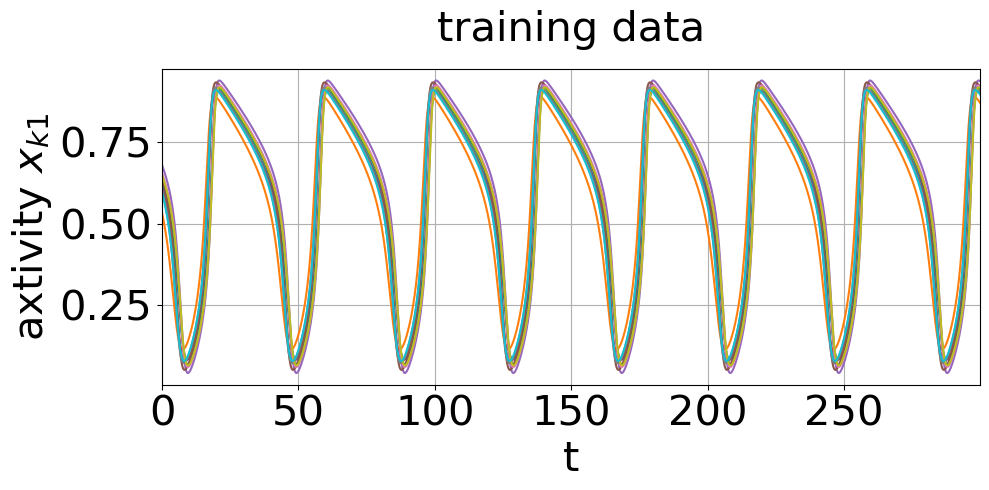

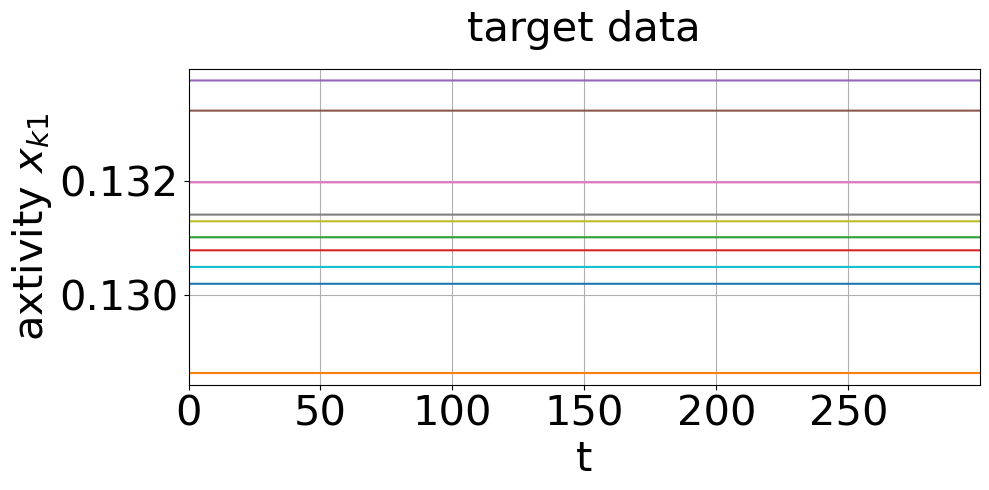

In [34]:
#calculate the uncontrolled state
nocontrol=torch.zeros((tsteps,parameters_low['N']))
state_uncontrolled=functions.plot_runge_kutta(functions.ODE_FHN_network,nocontrol, **args)

create_plot(state_uncontrolled[:,0,:],'axtivity $x_{k1}$','training data')
plt.show()
create_plot(target_output,'axtivity $x_{k1}$','target data')
plt.show()

In [35]:
adj = torch.ones(n_nodes,n_nodes)
torch.diagonal(adj, 0).zero_()

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [36]:
edge_index = adj.nonzero().t().contiguous()

In [37]:
edge_attr = A[edge_index[0], edge_index[1]]

In [13]:
state_uncontrolled.shape

torch.Size([1000, 2, 10])

In [11]:
test = give_target(parameters_high)

In [ ]:
adj = torch.ones(n_nodes,n_nodes)
torch.diagonal(adj, 0).zero_()
edge_index = adj.nonzero().t().contiguous()
edge_attr = A[edge_index[0], edge_index[1]]

# model

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        num_features = 2
        self.conv1 = GCNConv(num_features, 4)
        self.conv2 = GCNConv(4, 2)

    def forward(self, x,edge_index,edge_attr):
        num_features = x.shape[1]

        x = self.conv1(x, edge_index,edge_attr)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index,edge_attr)

        return x#F.log_softmax(x, dim=1)

# Training

In [38]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MetaLayer(EdgeModel(), NodeModel()).to(device)
data = state_uncontrolled.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
loss_fn = nn.MSELoss()
losses = []

model.train()
for epoch in range(100):
    loss_epoch = []
    for i in range(data.shape[0]-1):
        x = data[i,:,:].T
        y = data[i+1,:,:].T
        optimizer.zero_grad()
        out = model(x,edge_index,edge_attr)
        loss = loss_fn(out[0], y)
        loss.backward()
        optimizer.step()
        loss_epoch.append(loss.item())
    epoch_loss = sum(loss_epoch) / len(loss_epoch)
    losses.append(epoch_loss)

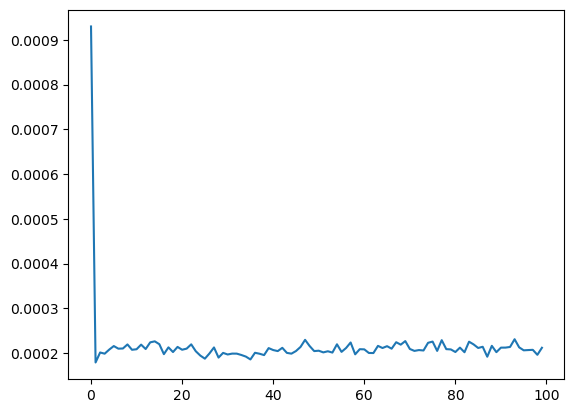

In [39]:
plt.plot(losses)
plt.show()

In [40]:
model.eval()
pred_traj = torch.zeros(data.shape[0],2,10)
pred_traj[0,:,:] = data[0,:,:]
for i in range(data.shape[0]-1):
    x = data[i,:,:].T
    pred = model(x,edge_index,edge_attr)[0]
    pred_traj[i+1,:,:] = pred.T


In [41]:
print(f'loss = {loss_fn(pred_traj,data)}')

loss = 0.010332908481359482


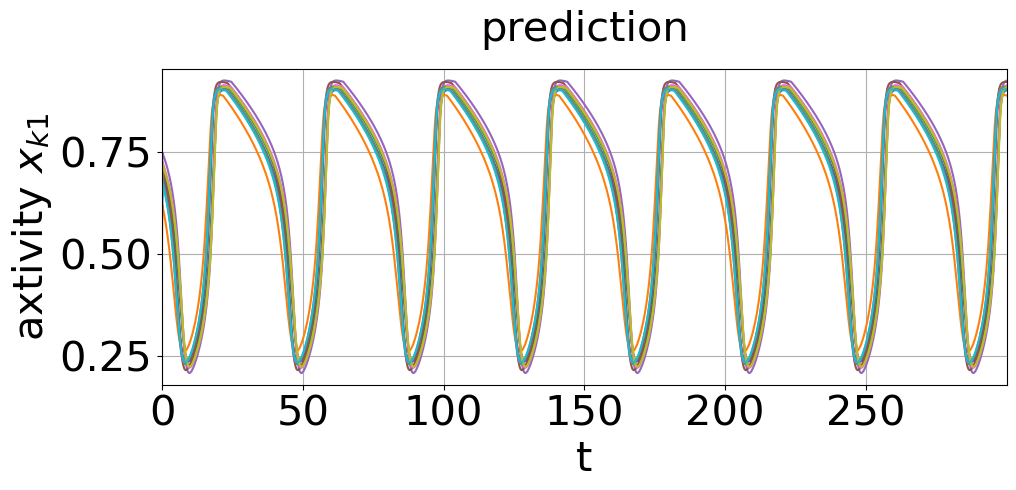

In [42]:
create_plot(pred_traj[:,0,:].detach(),'axtivity $x_{k1}$','prediction')

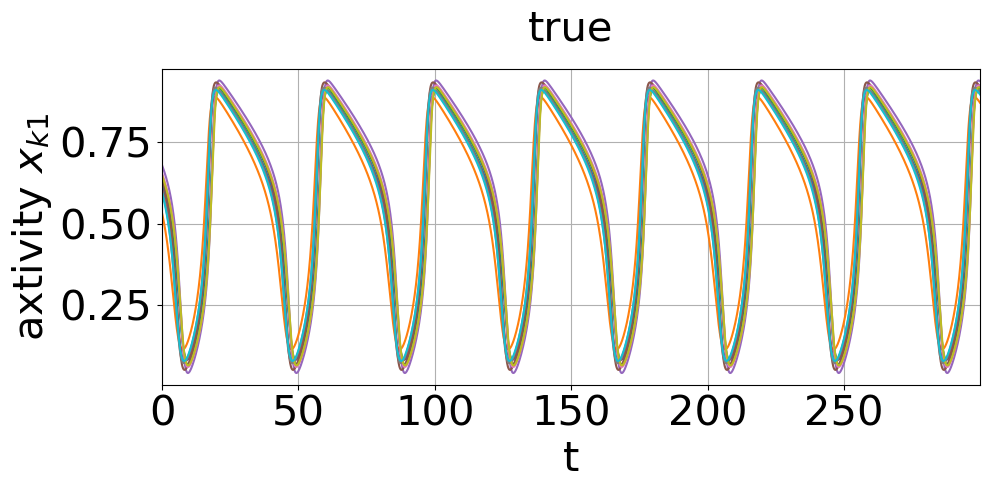

In [43]:
create_plot(state_uncontrolled[:,0,:],'axtivity $x_{k1}$','true')

In [103]:
model.eval()
pred_test = torch.zeros(data.shape[0],2,10)
pred_test[0,:,:] = test[0,:,:]
for i in range(test.shape[0]-1):
    x = test[i,:,:].T
    pred = model(x,edge_index,edge_attr)
    pred_test[i+1,:,:] = pred.T

In [104]:
print(f'loss = {loss_fn(pred_test,test)}')

loss = 0.02228403091430664


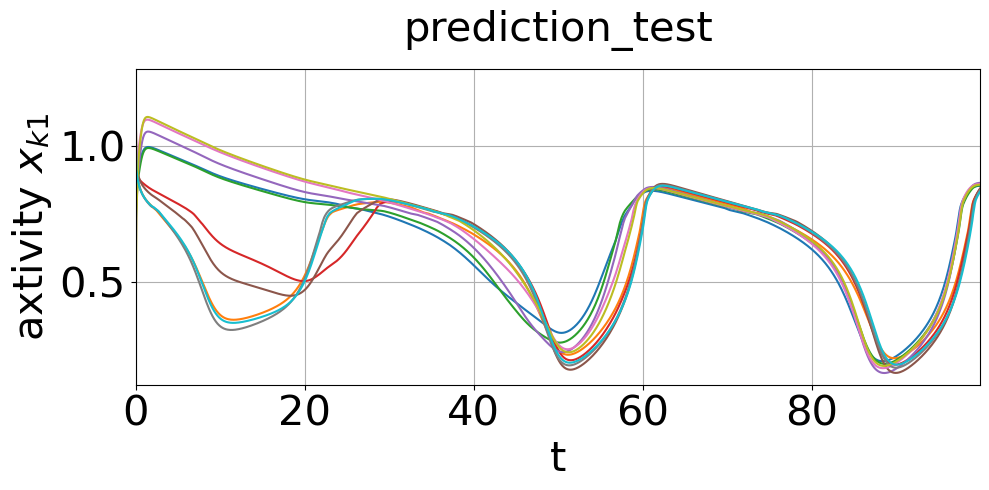

In [105]:
create_plot(pred_test[:,0,:].detach(),'axtivity $x_{k1}$','prediction_test')

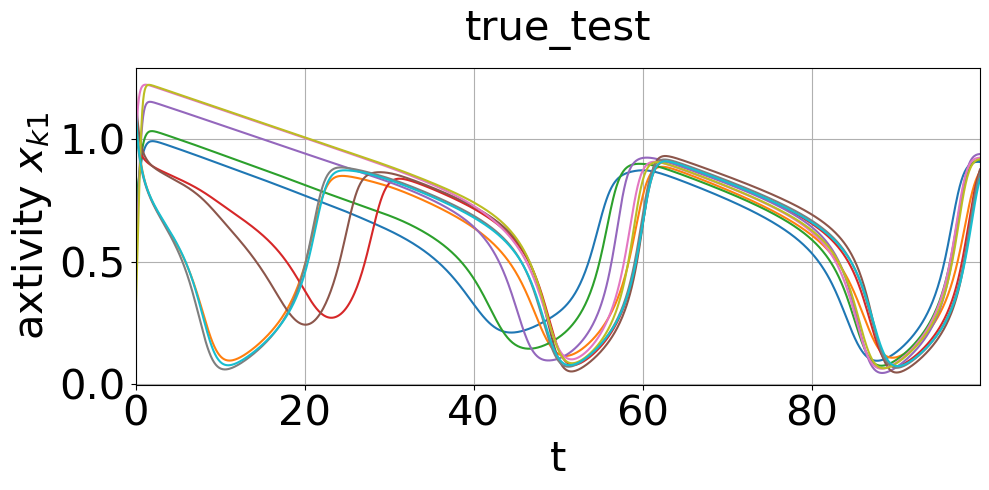

In [93]:
create_plot(test[:,0,:].detach(),'axtivity $x_{k1}$','true_test')

## control

In [44]:
for param in model.parameters():
    param.requires_grad = False

In [27]:
def f_switch_torch(control,tsteps , d , dt , N , I_p , I_e , I_s , alpha , beta, gamma, delta, epsilon, tau, mu ,sigma, A,  target_output ,node_ic,realizations,noise):

    adj = torch.ones(N,N)
    torch.diagonal(adj, 0).zero_()
    edge_index = adj.nonzero().t().contiguous()
    edge_attr = A[edge_index[0], edge_index[1]]

    control=control.view(tsteps,N)
    if not isinstance(control, torch.Tensor):
        control = torch.tensor(control, dtype=torch.float32, requires_grad=True)
    elif not control.requires_grad:
        control.requires_grad_(True)

    state = torch.zeros(tsteps,2,N)
    state[0,:,:] = node_ic
    for i in range(tsteps-1):
        x = state[i,:,:].T
        pred = model(x,edge_index,edge_attr)[0]
        state[i+1,:,:] = pred.T

    state_diff_2=(state[:,0,:]-  target_output)**2
    f1= 1/2  * (I_p*state_diff_2).sum() 
    f2= I_e/2 * (control**2).sum() 
    if I_s>1e-10:
        controlsum = torch.sum(control**2, axis=0)**(1.0 / 2.0)#
        f3 = I_s  *torch.sum(controlsum)
    else:
        f3=0
    return (f1+f2+f3) 

def fprime_switch_torch(control,tsteps , d , dt , N , I_p , I_e , I_s , alpha , beta, gamma, delta, epsilon, tau, mu ,sigma, A,  target_output ,node_ic,realizations,noise):
    if not isinstance(control, torch.Tensor):
        control = torch.tensor(control, dtype=torch.float32, requires_grad=True)
    elif not control.requires_grad:
        control.requires_grad_(True)

    # compute the function value
    y = f_switch_torch(control,tsteps , d , dt , N , I_p , I_e , I_s , alpha , beta, gamma, delta, epsilon, tau, mu ,sigma, A,  target_output ,node_ic,realizations,noise)
    # backward() computes the gradient and accumulates it in x.grad
    torch.autograd.set_detect_anomaly(True)
    y.backward()

    return  control.grad

def cross_correlation_matrix(x , tsteps , N):
    if not isinstance(x, torch.Tensor):
        x = torch.tensor(x, dtype=torch.float32, requires_grad=True)
    elif not x.requires_grad:
        x.requires_grad_(True)
    x.retain_grad()
    means = (1/tsteps) * torch.sum(x, dim=0)
    stds = torch.sqrt(torch.sum((x - means)**2, dim=0))
    stdsgrid = torch.ones((N, 1)) * stds
    stdsgrid = stdsgrid.transpose(0, 1) * stdsgrid
    xcc = x - means
    cross_correlation_mat = torch.matmul(xcc.transpose(0, 1), xcc) / stdsgrid

    return cross_correlation_mat 

def f_sync_torch(control,tsteps , d , dt , N ,   I_p ,   I_e ,   I_s , alpha , beta, gamma, delta, epsilon, tau, mu ,sigma, A,  target_output ,node_ic,realizations,noise):
    adj = torch.ones(N,N)
    torch.diagonal(adj, 0).zero_()
    edge_index = adj.nonzero().t().contiguous()
    edge_attr = A[edge_index[0], edge_index[1]]
    
    control=control.view(tsteps,N)

    if not isinstance(control, torch.Tensor):
        control = torch.tensor(control, dtype=torch.float32, requires_grad=True)
    elif not control.requires_grad:
        control.requires_grad_(True)
    control.retain_grad()
    
    state = torch.zeros(tsteps,2,N)
    state[0,:,:] = node_ic
    for i in range(tsteps-1):
        x = state[i,:,:].T
        pred = model(x,edge_index,edge_attr)[0]
        state[i+1,:,:] = pred.T
    state = state[:,0,:]
    #print(state)
    cc = cross_correlation_matrix(state , tsteps , N)
    f1 =   I_p * (1/4)* torch.sum((cc -   target_output)**2)
    f2=   I_e/2 * (control**2).sum() 
    if   I_s>1e-10:
        controlsum= torch.sum(control**2, dim=0)**(1.0 / 2.0)#
        f3 =   I_s  *torch.sum(controlsum)
    else:
        f3=0
    return (f1+f2+f3) 

def fprime_sync_torch(control,tsteps , d , dt , N , I_p , I_e , I_s , alpha , beta, gamma, delta, epsilon, tau, mu ,sigma, A,  target_output ,node_ic,realizations,noise):

    control=control.view(tsteps,N)
    if not isinstance(control, torch.Tensor):
        control = torch.tensor(control, dtype=torch.float32, requires_grad=True)
    elif not control.requires_grad:
        control.requires_grad_(True)
    control.retain_grad()
    # compute the function value
    y = f_sync_torch(control,tsteps , d , dt , N , I_p , I_e , I_s , alpha , beta, gamma, delta, epsilon, tau, mu ,sigma, A,  target_output ,node_ic,realizations,noise)
    # backward() computes the gradient and accumulates it in x.grad
    #torch.autograd.set_detect_anomaly(True)
    y.backward()

    return  control.grad.view(tsteps*N)

In [45]:
#define the functional and its gradient
functional=f_switch_torch
gradient=fprime_switch_torch

control=-torch.ones((tsteps,parameters_low['N']))*0.002
control=control.reshape(tsteps*parameters_low['N'])
#initialize the control loop
iteration=0 
#warnflag=1-> running, warnflag=0->finished, warnflag=3->error
warnflag=1
#start the optmization
result = FR_algorithm(functional, control, gradient, max_k=1000, **args)
control=result[0]
warnflag=result[2]
iteration+=result[4]
print('Code finished after ',iteration,' iterations with warnflag',result[2])

gnorm tensor(5.0000e-05) uknorm tensor(0.0025, grad_fn=<MaxBackward1>)
Code finished after  2  iterations with warnflag 0


In [49]:
result[5]

[tensor(0.3831), tensor(0.3774)]

In [50]:
result[6]

[tensor([-0.0002, -0.0002, -0.0002,  ..., -0.0002, -0.0002, -0.0002]),
 tensor([5.0000e-05, 5.0000e-05, 5.0000e-05,  ..., 5.0000e-05, 5.0000e-05,
         5.0000e-05])]

In [46]:
control=control.reshape(tsteps,parameters_low['N'])
state_controlled=functions.plot_runge_kutta(functions.ODE_FHN_network,control, **args)

In [48]:
tsteps

3000

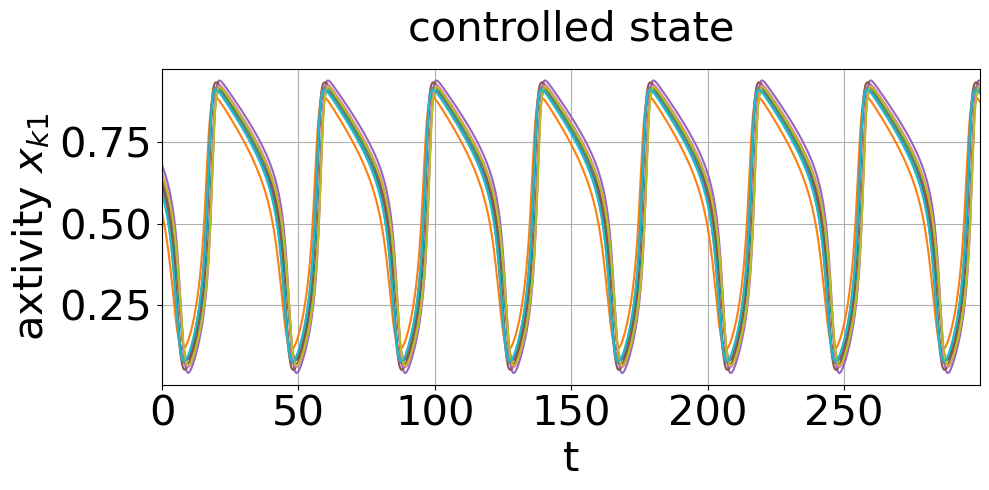

/var/folders/rr/j6h778k96l3cmvkjn2gmtjt40000gn/T/ipykernel_12651/3761200564.py:13: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(minn-add,maxx+add)


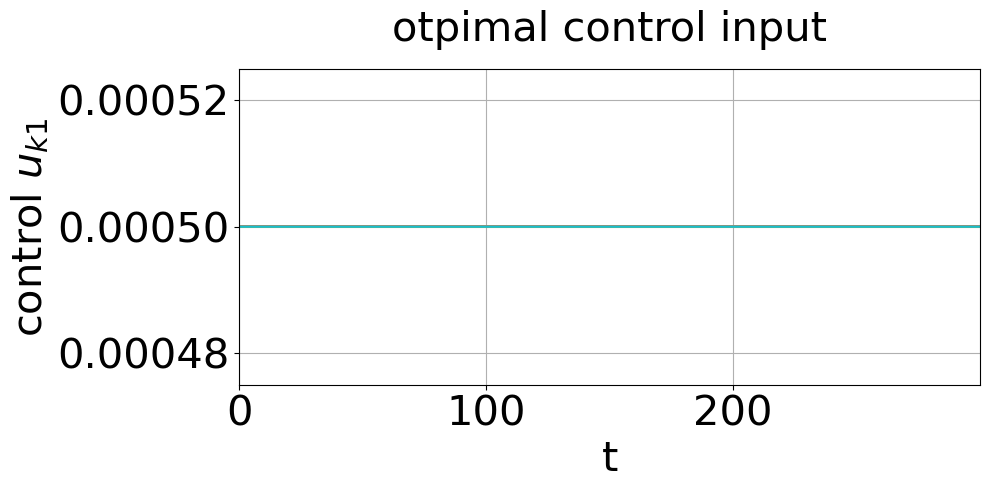

In [47]:
create_plot(state_controlled[:,0,:].detach(),'axtivity $x_{k1}$','controlled state')
plt.show()
create_plot(control.detach(),'control $u_{k1}$','otpimal control input')
plt.show()

## larger network

In [17]:
T= 500 #simulation and control time 
dt=0.1 #time stepsize
tsteps=int(T/dt) #number of timesteps

def give_target(parameters,ic):
    alpha=parameters['alpha']
    beta=parameters['beta']
    gamma=parameters['gamma']
    delta=parameters['delta']
    epsilon=parameters['epsilon']
    tau=parameters['tau']
    sigma=parameters['sigma']
    mu=parameters['mu']
    A=parameters['A']
    N=parameters['N']
    control=torch.zeros((tsteps,N))

    target_state=functions.runge_kutta_FHN_network(ic, control,  tsteps , d , dt , N, alpha , beta, gamma, delta, epsilon, tau, mu ,sigma, A)
    return target_state

parameters_large = functions.set_parameters(goal,'high',parentDir)
ic_large=functions.set_random_initial_conds_for_nodes('high',noise_strength,tsteps,d,dt,parameters_large,realizations,noise)
target_output_large = give_target(parameters_large,ic_large)

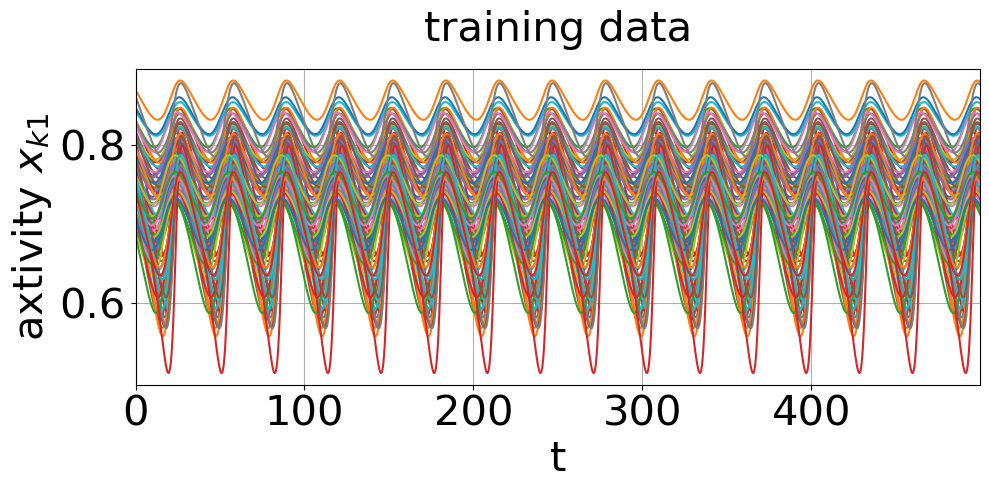

In [18]:
create_plot(target_output_large[:,0,:],'axtivity $x_{k1}$','training data')
plt.show()

In [19]:
edge_attr_large = parameters_large['A'][edge_index[0], edge_index[1]]

In [20]:
class GCN_large(torch.nn.Module):
    def __init__(self):
        super().__init__()
        num_features = 2
        self.conv1 = GCNConv(num_features, 8)
        self.conv2 = GCNConv(8, 16)
        self.conv3 = GCNConv(16, 8)
        self.conv4 = GCNConv(8, 2)

    def forward(self, x,edge_index,edge_attr):
        num_features = x.shape[1]

        x = self.conv1(x, edge_index,edge_attr)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index,edge_attr)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv3(x, edge_index,edge_attr)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv4(x, edge_index,edge_attr)

        return x#F.log_softmax(x, dim=1)

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN_large().to(device)
data = target_output_large.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
loss_fn = nn.MSELoss()

losses = []
model.train()
for epoch in range(200):
    loss_epoch = []
    for i in range(data.shape[0]-1):
        x = data[i,:,:].T
        y = data[i+1,:,:].T
        optimizer.zero_grad()
        out = model(x,edge_index,edge_attr)
        loss = loss_fn(out, y)
        loss.backward()
        optimizer.step()
        loss_epoch.append(loss.item())
    epoch_loss = sum(loss_epoch) / len(loss_epoch)
    losses.append(epoch_loss)

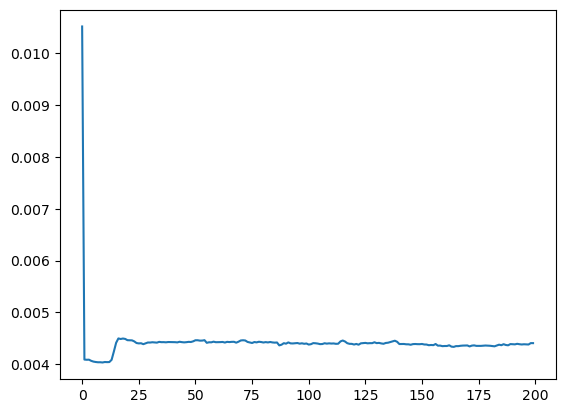

In [22]:
plt.plot(losses)
plt.show()

In [23]:
model.eval()
pred_traj = torch.zeros(data.shape[0],2,94)
pred_traj[0,:,:] = data[0,:,:]
for i in range(data.shape[0]-1):
    x = data[i,:,:].T
    pred = model(x,edge_index,edge_attr)
    pred_traj[i+1,:,:] = pred.T


In [26]:
print(f'loss = {loss_fn(pred_traj,data)}')

loss = 0.006573664955794811


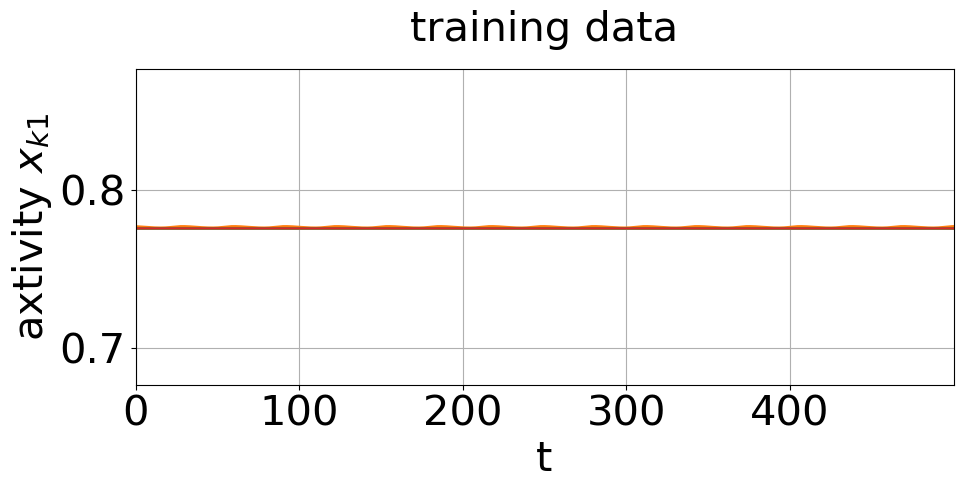

In [25]:
create_plot(pred_traj[:,0,:].detach(),'axtivity $x_{k1}$','training data')
plt.show()

In [4]:
import random
seed=50
random.seed(seed)
goal='sync'
#choose to simulate close to low or high bifurcation of the network dynamics in the state space
#needed for choosing the parameters sigma and mu
bifurcation='low'
#strenght of normalized gaussian white noise
noise_strength= 0.0 
#set network parameters
parameters = functions.set_parameters(goal,bifurcation,parentDir) # set node an network parameters: alpha,beta,gamma,delta,tau,epsilon,sigma,mu,A,N

#set paraeters of the cost functional
I_p_in= 0.0005 #penalize precision
I_e= 1.0 #penalize control energy should be >0
I_s= 0.0#enforce sparsity

#Set dimensions
T= 400 #simulation and control time 
dt=0.1 #time stepsize
tsteps=int(T/dt) #number of timesteps
d=2 #dimension of each FitzHugh-Nagumo node

#if multiple realizations: set realization number
run=0

if goal=='switch':
    #set whether a switch from the low to high state or the opposite should be made
    #can be either 'lowtohigh' or 'hightolow'
    switchfromto='hightolow'#'lowtohigh' 
    #the presision is only penalized at the last 25 timeunits, to give the system time to switch
    I_p=torch.zeros((tsteps,parameters['N']))
    I_p[int(tsteps-25/dt):]=I_p_in*torch.ones((int(25/dt),parameters['N']))
elif goal=='sync':
    switchfromto='none'
    I_p=I_p_in
    
######################### INITIALIZATION ############################

#initialize noise if the noise-strenght is not zero:
if noise_strength !=0.0:
    realizations=20 #number of noise realizations over which to take the mean to calculate the cost functional
    noise=functions.initialize_noise(noise_strength,dt,realizations,tsteps,parameters['N'])
else:
    realizations=1
    noise=0

#choose initial condition for control, should not be 0 if I_s>0
control=-torch.ones((tsteps,parameters['N']))*0.002
control=control.reshape(tsteps*parameters['N'])

#Check that parameters are chosen correctly
functions.check_parameters(goal,bifurcation,switchfromto,noise_strength,I_p_in,I_e,I_s,control.reshape(tsteps,parameters['N']))

#initialize the node acivity and set target output
if goal=='sync': 
    # uuse random node inis
    node_ic=functions.set_random_initial_conds_for_nodes(bifurcation,noise_strength,tsteps,d,dt,parameters,realizations,noise)
    #target output is a cross correlation of one for all pairs of nodes equal to one
    target_output=torch.ones((parameters['N'],parameters['N']))

elif goal=='switch':  
    #read node inis from file, target_output is the state we want to switch to
    node_ic,target_output=functions.read_node_inis_from_file(bifurcation,switchfromto,fileDir,tsteps,d,dt,parameters)



#make dictionary with all parameters
args = {
    'tsteps':tsteps,
    'dt':dt,
    'd':d,
    'I_p':I_p,
    'I_e':I_e,
    'I_s':I_s,
    'target_output':target_output,
    'node_ic':node_ic,
    'realizations':realizations,
    'noise':noise
    }
args.update(parameters)

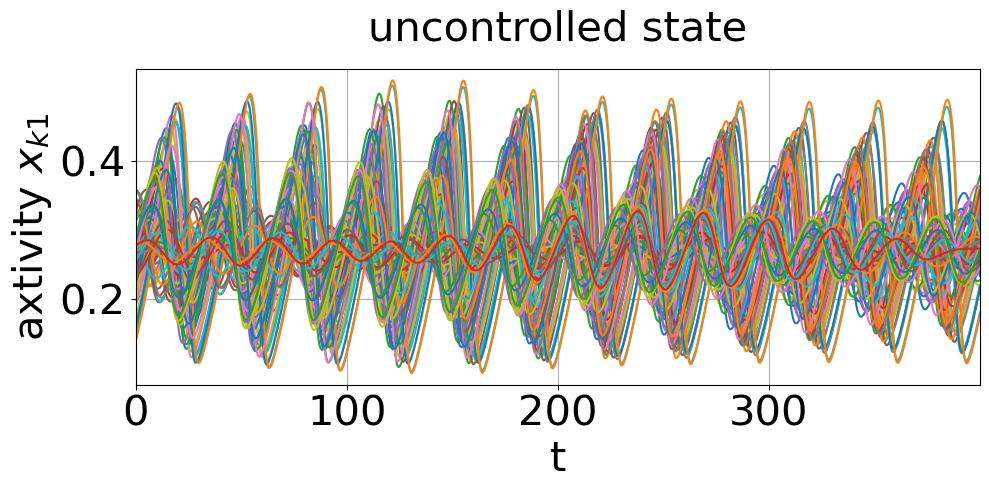

In [5]:
nocontrol=torch.zeros((tsteps,parameters['N']))
state_uncontrolled=functions.plot_runge_kutta(functions.ODE_FHN_network,nocontrol, **args)
create_plot(state_uncontrolled[:,0,:],'axtivity $x_{k1}$','uncontrolled state')
plt.show()

In [6]:
A_large = parameters['A']
n_nodes_large = parameters['N']

adj_large = torch.ones(n_nodes_large,n_nodes_large)
torch.diagonal(adj_large, 0).zero_()
edge_index_large = adj_large.nonzero().t().contiguous()
edge_attr_large = A_large[edge_index_large[0], edge_index_large[1]]

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MetaLayer(EdgeModel(), NodeModel()).to(device)
data = state_uncontrolled.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
loss_fn = nn.MSELoss()
losses = []

model.train()
for epoch in range(100):
    loss_epoch = []
    for i in range(data.shape[0]-1):
        x = data[i,:,:].T
        y = data[i+1,:,:].T
        optimizer.zero_grad()
        out = model(x,edge_index_large,edge_attr_large)
        loss = loss_fn(out[0], y)
        loss.backward()
        optimizer.step()
        loss_epoch.append(loss.item())
    epoch_loss = sum(loss_epoch) / len(loss_epoch)
    losses.append(epoch_loss)

In [13]:
torch.save(model.state_dict(), 'GNN_metalayer')

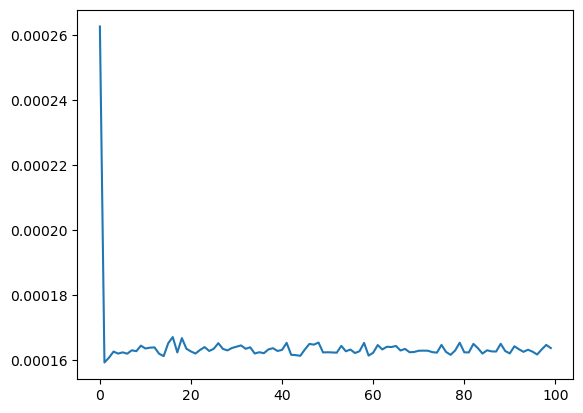

In [10]:
plt.plot(losses)
plt.show()

In [11]:
model.eval()
pred_traj = torch.zeros(data.shape[0],2,94)
pred_traj[0,:,:] = data[0,:,:]
for i in range(data.shape[0]-1):
    x = data[i,:,:].T
    pred = model(x,edge_index_large,edge_attr_large)[0]
    pred_traj[i+1,:,:] = pred.T


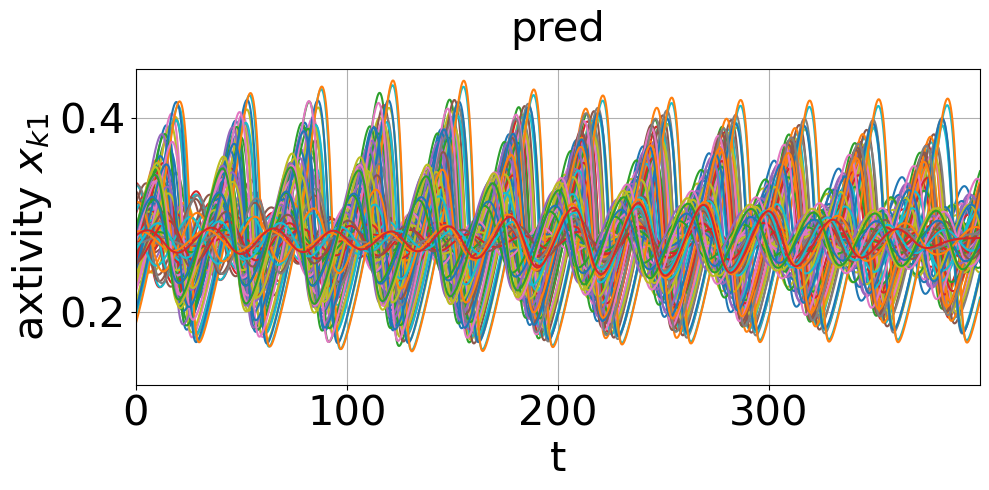

In [12]:
create_plot(pred_traj[:,0,:].detach(),'axtivity $x_{k1}$','pred')

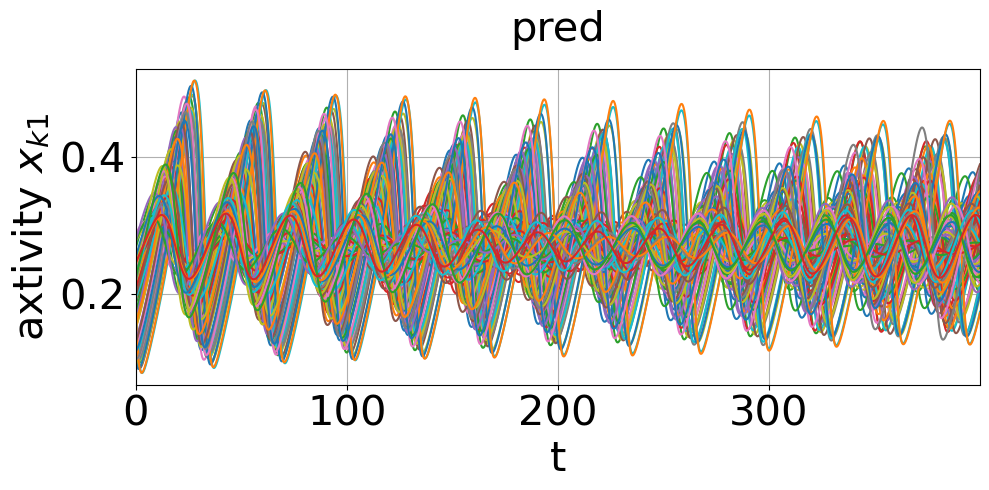

In [33]:
create_plot(data[:,0,:],'axtivity $x_{k1}$','pred')

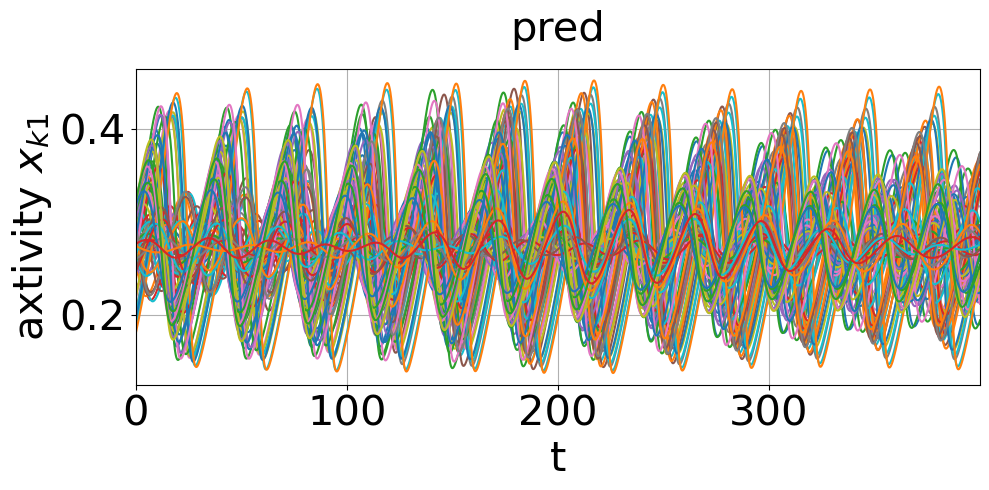

In [173]:
create_plot(pred_traj[:,0,:].detach(),'axtivity $x_{k1}$','pred')

In [ ]:
#define the functional and its gradient
functional=f_sync_torch
gradient=fprime_sync_torch

control=-torch.ones((tsteps,parameters['N']))*0.002
control=control.reshape(tsteps*parameters['N'])
#initialize the control loop
iteration=0 
#warnflag=1-> running, warnflag=0->finished, warnflag=3->error
warnflag=1
#start the optmization
result = FR_algorithm(functional, control, gradient, max_k=1000, **args)
control=result[0]
warnflag=result[2]
iteration+=result[4]
print('Code finished after ',iteration,' iterations with warnflag',result[2])

In [35]:
result[5]

[tensor(0.7520), tensor(0.2379), tensor(0.2379)]

In [36]:
result[6]

[tensor([-0.0020, -0.0020, -0.0020,  ..., -0.0020, -0.0020, -0.0020]),
 tensor([0.0011, 0.0011, 0.0011,  ..., 0.0011, 0.0011, 0.0011]),
 tensor([0.0011, 0.0011, 0.0011,  ..., 0.0011, 0.0011, 0.0011])]

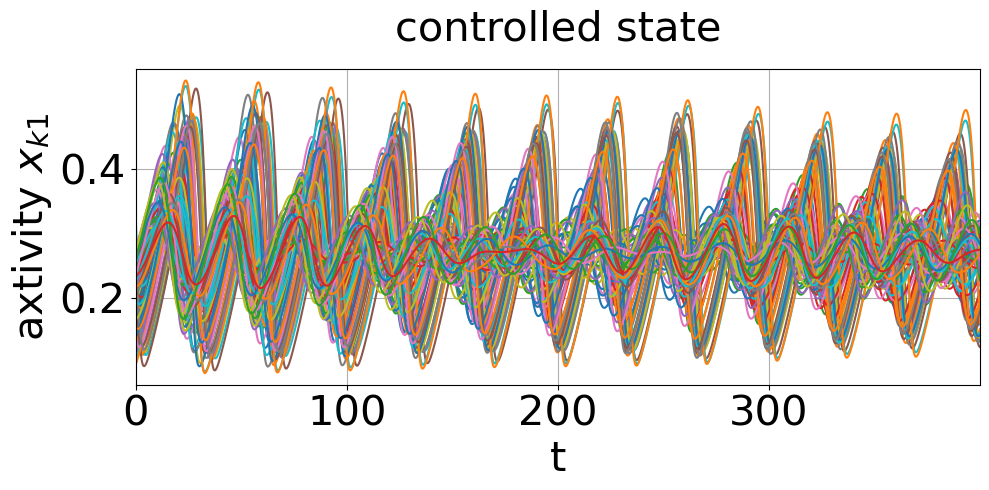

In [22]:
control=control.reshape(tsteps,parameters['N'])
state_controlled=functions.plot_runge_kutta(functions.ODE_FHN_network,control, **args)

create_plot(state_controlled[:,0,:].detach(),'axtivity $x_{k1}$','controlled state')
plt.show()

## metalayer

In [14]:
import torch
from torch import nn
from torch.nn import Sequential, Linear, ReLU
from torch_geometric.utils import scatter
from torch_geometric.nn import MetaLayer

class EdgeModel(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, src, dst, edge_attr,u=None,batch=None):
        # src, dst: [E, F_x], where E is the number of edges.
        # edge_attr: [E, F_e]
        # u: [B, F_u], where B is the number of graphs.
        # batch: [E] with max entry B - 1.
        #if edge_attr.dim() == 1:
            #edge_attr = edge_attr.view(-1, 1)
        #print(dst[:,0,:].shape,edge_attr.shape)
        #print(dst[:,0].shape,edge_attr.shape)
        dst[:,0] = dst[:,0] * edge_attr
        

        return dst

class NodeModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        in_channels = 4
        hiddens = 8
        self.node_mlp_1 = Sequential(
            nn.Linear(in_channels, hiddens),
            nn.ReLU(),
            nn.Linear(hiddens, 2*hiddens),
            nn.ReLU(),
            nn.Linear(2*hiddens, in_channels))
        in_2 = 2
        num_node_features = 2
        self.node_mlp_2 = Sequential(
            nn.Linear(in_channels+in_2, 2*hiddens),
            nn.ReLU(),
            nn.Linear(2*hiddens, num_node_features))

    def forward(self, x, edge_index, edge_attr,u=None,batch=None):
        # x: [N, F_x], where N is the number of nodes.
        # edge_index: [2, E] with max entry N - 1.
        # edge_attr: [E, F_e]
        # u: [B, F_u]
        # batch: [N] with max entry B - 1.
        row, col = edge_index
        #print(x[row].shape,edge_attr.shape)
        out = torch.cat([x[row], edge_attr], dim=1)
        out = self.node_mlp_1(out)
        #print(out.shape)
        out = scatter(out, col, dim=0, dim_size=x.size(0),
                      reduce='mean')
        #print(x.shape,out.shape)
        out = torch.cat([x, out], dim=1)
        return self.node_mlp_2(out)

In [156]:
op = MetaLayer(EdgeModel(), NodeModel())
results_1 = op(data[0,:,:].T, edge_index, edge_attr)

In [157]:
results_1[0].shape

torch.Size([10, 2])

In [158]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MetaLayer(EdgeModel(), NodeModel()).to(device)
data = state_uncontrolled.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
loss_fn = nn.MSELoss()
losses = []

model.train()
for epoch in range(100):
    loss_epoch = []
    for i in range(data.shape[0]-1):
        x = data[i,:,:].T
        y = data[i+1,:,:].T
        optimizer.zero_grad()
        out = model(x,edge_index,edge_attr)
        loss = loss_fn(out[0], y)
        loss.backward()
        optimizer.step()
        loss_epoch.append(loss.item())
    epoch_loss = sum(loss_epoch) / len(loss_epoch)
    losses.append(epoch_loss)

In [159]:
model.eval()
pred_traj = torch.zeros(data.shape[0],2,10)
pred_traj[0,:,:] = data[0,:,:]
for i in range(data.shape[0]-1):
    x = data[i,:,:].T
    pred = model(x,edge_index,edge_attr)[0]
    pred_traj[i+1,:,:] = pred.T


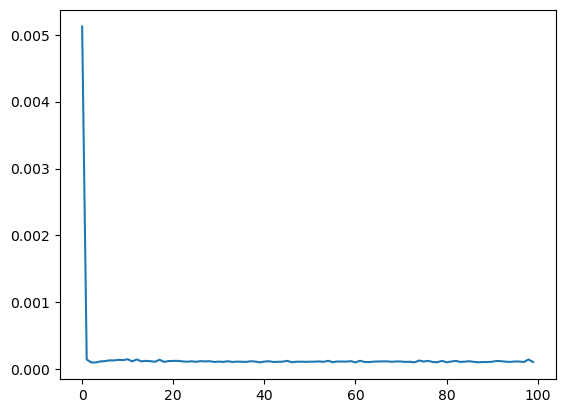

In [163]:
plt.plot(losses)
plt.show()

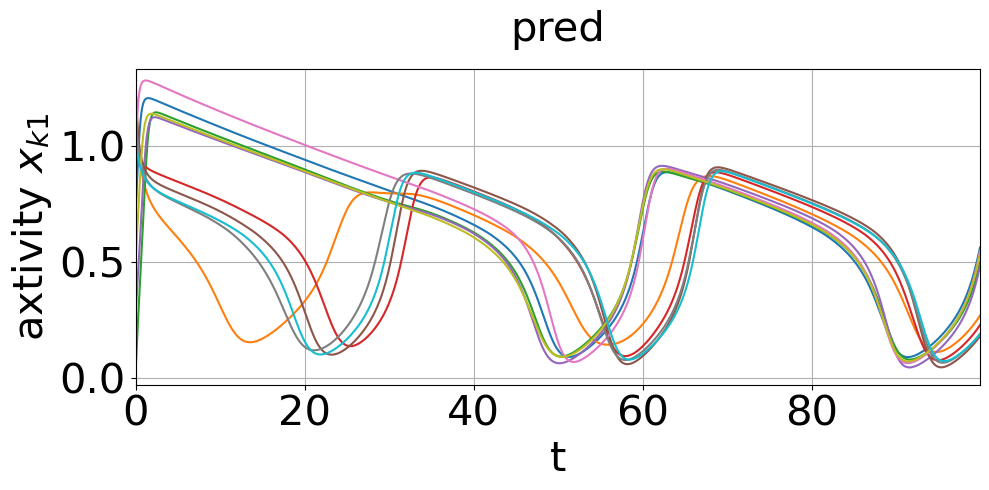

In [160]:
create_plot(pred_traj[:,0,:].detach(),'axtivity $x_{k1}$','pred')

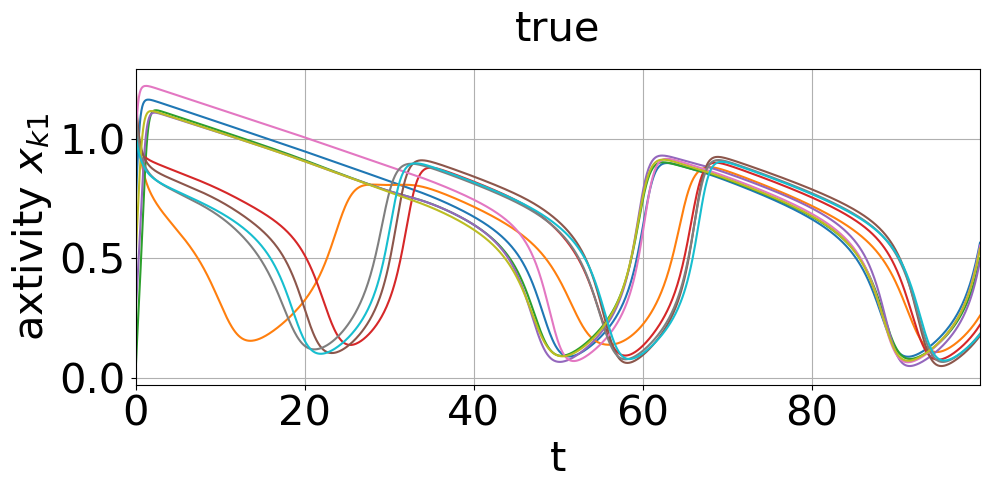

In [162]:
create_plot(data[:,0,:].detach(),'axtivity $x_{k1}$','true')